In [1]:
%matplotlib inline
from math import pi, sin, cos, tan
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import openmc

In [2]:
temp=[294,294,294,294,294,294]

In [3]:
#material
#h21
h21=openmc.Material(name='h21',temperature=temp[0])
h21.set_density('g/cm3', 6.61453E-4)
h21.add_nuclide('H1',1.0)
#uzrc
uzrc=openmc.Material(name='uzrc',temperature=temp[1])
uzrc.set_density('g/cm3', 7.13697427)
uzrc.add_nuclide('U235',0.0035)
uzrc.add_nuclide('U238',0.0965)
uzrc.add_element('Zr', 1.0)
uzrc.add_element('C', 0.92)
#h22
h22=openmc.Material(name='h22',temperature=temp[2])
h22.set_density('g/cm3', 6.61453E-4)
h22.add_nuclide('H1',1.0)
#zrh
zrh=openmc.Material(name='zrh',temperature=temp[3])
zrh.set_density('g/cm3', 5.6)
zrh.add_element('Zr', 1.0)
zrh.add_nuclide('H1',2.0)
#beo
beo=openmc.Material(name='beo',temperature=temp[4])
beo.set_density('g/cm3', 3.025)
beo.add_element('Be', 1.0)
beo.add_element('O', 1.0)
#b4c
b4c=openmc.Material(name='b4c',temperature=temp[5])
b4c.set_density('g/cm3', 2.52)
b4c.add_nuclide('B10',0.2)
b4c.add_nuclide('B11',0.8)
b4c.add_element('C',1.0)
#materail.xml
materials = openmc.Materials([h21,uzrc,h22,zrh,beo,b4c])
materials.export_to_xml()
!cat materials.xml

<?xml version='1.0' encoding='utf-8'?>
<materials>
  <material id="1" name="h21" temperature="294">
    <density units="g/cm3" value="0.000661453" />
    <nuclide ao="1.0" name="H1" />
  </material>
  <material depletable="true" id="2" name="uzrc" temperature="294">
    <density units="g/cm3" value="7.13697427" />
    <nuclide ao="0.0035" name="U235" />
    <nuclide ao="0.0965" name="U238" />
    <nuclide ao="0.5145" name="Zr90" />
    <nuclide ao="0.1122" name="Zr91" />
    <nuclide ao="0.1715" name="Zr92" />
    <nuclide ao="0.1738" name="Zr94" />
    <nuclide ao="0.028" name="Zr96" />
    <nuclide ao="0.92" name="C0" />
  </material>
  <material id="3" name="h22" temperature="294">
    <density units="g/cm3" value="0.000661453" />
    <nuclide ao="1.0" name="H1" />
  </material>
  <material id="4" name="zrh" temperature="294">
    <density units="g/cm3" value="5.6" />
    <nuclide ao="0.5145" name="Zr90" />
    <nuclide ao="0.1122" name="Zr91" />
    <nuclide ao="0.1715" name="Zr92"

In [4]:
#surface
#surface
inner_room_radius=openmc.ZCylinder(r=0.63)
fuel_ring_outer_radius=openmc.ZCylinder(r=2.0)
outer_room_radius=openmc.ZCylinder(r=2.5)
active_zone_radius=openmc.ZCylinder(r=47.0)
radial_buffer_radius=openmc.ZCylinder(r=59.0,boundary_type='vacuum')
bot_buffer=openmc.ZPlane(z0=-10,boundary_type='vacuum')
bot_active_zone=openmc.ZPlane(z0=0)
top_active_zone=openmc.ZPlane(z0=120)
top_buffer=openmc.ZPlane(z0=140,boundary_type='vacuum')

In [5]:
#cell&universe
# u of fuel
inner_room=openmc.Cell(fill=h21,region=-inner_room_radius)
fuel=openmc.Cell(fill=uzrc,region=+inner_room_radius & -fuel_ring_outer_radius)
outer_room=openmc.Cell(fill=h22,region=+fuel_ring_outer_radius & -outer_room_radius)
moderater=openmc.Cell(fill=zrh,region=+outer_room_radius)
element=openmc.Universe(cells=(inner_room,fuel,outer_room,moderater))
# u of buffer
void_inner=openmc.Cell(fill=beo,region=-inner_room_radius)
void_outer=openmc.Cell(fill=beo,region=+inner_room_radius)
void_element=openmc.Universe(cells=(void_inner,void_outer))

In [6]:
lattice = openmc.HexLattice()
lattice.orientation = 'y'
lattice.center = (0.0, 0.0)
lattice.pitch = [6.0]
outer=openmc.Cell(fill=beo)
outer_universe=openmc.Universe(cells=(outer,))
lattice.outer = outer_universe
lattice.universes = [([void_element]*2+[element]*5+[void_element]*1)*6,[element]*42,[element]*36,[element]*30,[element]*24,[element]*18,[element]*12,[element]*6,[element]]
main_cell = openmc.Cell(fill=lattice, region=-active_zone_radius & +bot_active_zone & -top_active_zone)

In [7]:
outer_drum_radius=openmc.ZCylinder(r=5.5)
inner_drum_radius=openmc.ZCylinder(r=3.5)
buffer_cell=openmc.Cell(fill=beo,region=+active_zone_radius & -radial_buffer_radius)
buffer_universe=openmc.Universe(cells=(buffer_cell,))
ang=[0,15,30,45,60,75,90,105,120,135,150,165,180]
#ang=[0,0,0,0,0,0,0,0,0,0,0,0,0]
drum_a_data=1.0
#drum_b_data=tan(ang[0]/180*pi)
drum_c_data=0
drum_d_data=0
for i in range(0,12):
    theta=(15+30*i)*pi/180
    x=53*cos(theta)
    y=53*sin(theta)
    drum_boundary=openmc.ZCylinder(x0=x, y0=y, r=5.5)
    buffer_cell.region=buffer_cell.region & +drum_boundary
    drum_a_data=cos((ang[0])/180*pi+theta)
    drum_b_data=sin((ang[0])/180*pi+theta)
    drum_cut=openmc.Plane(a=drum_a_data,b=drum_b_data,c=drum_c_data,d=drum_d_data)
    b4c_part=openmc.Cell(fill=b4c,region=+inner_drum_radius & -outer_drum_radius & +drum_cut)
    beo_part=openmc.Cell(fill=beo,region=~(+inner_drum_radius & -outer_drum_radius & +drum_cut))
    control_drum_universe=openmc.Universe(cells=(b4c_part, beo_part))
    
    drum=openmc.Cell(fill=control_drum_universe, region=-drum_boundary)
    drum.translation=(x,y,0)
    buffer_universe.add_cell(drum)
buffer=openmc.Cell(fill=buffer_universe,region=+active_zone_radius & -radial_buffer_radius & +bot_active_zone & -top_active_zone)

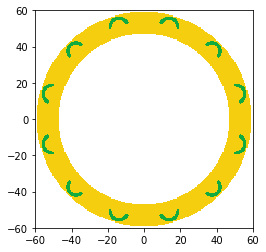

In [8]:
buffer_universe.plot(width=(120,120),basis='xy',color_by='material')

In [9]:
top_buffer=openmc.Cell(fill=beo,region=+top_active_zone & -radial_buffer_radius & -top_buffer)
bot_buffer=openmc.Cell(fill=beo,region=-bot_active_zone & +bot_buffer & -radial_buffer_radius)

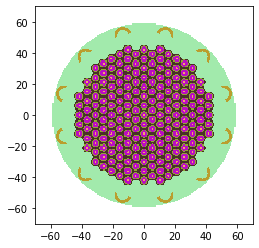

In [10]:
draw_universe = openmc.Universe(cells=(main_cell,buffer))
draw_universe.plot(width=[140,140],color_by='material')


In [11]:
root_universe = openmc.Universe(cells=(main_cell,buffer,top_buffer,bot_buffer))
geometry = openmc.Geometry(root_universe)
geometry.export_to_xml()
!cat geometry.xml

<?xml version='1.0' encoding='utf-8'?>
<geometry>
  <cell id="1" material="1" region="-1" universe="1" />
  <cell id="2" material="2" region="1 -2" universe="1" />
  <cell id="3" material="3" region="2 -3" universe="1" />
  <cell id="4" material="4" region="3" universe="1" />
  <cell id="5" material="5" region="-1" universe="2" />
  <cell id="6" material="5" region="1" universe="2" />
  <cell id="7" material="5" universe="4" />
  <cell fill="3" id="8" region="-4 7 -8" universe="19" />
  <cell id="9" material="5" region="4 -5 12 14 16 18 20 22 24 26 28 30 32 34" universe="5" />
  <cell id="10" material="6" region="11 -10 13" universe="6" />
  <cell id="11" material="5" region="~(11 -10 13)" universe="6" />
  <cell fill="6" id="12" region="-12" translation="51.19406879332062 13.717409390433598 0.0" universe="5" />
  <cell id="13" material="6" region="11 -10 15" universe="7" />
  <cell id="14" material="5" region="~(11 -10 15)" universe="7" />
  <cell fill="7" id="15" region="-14" transla

In [12]:
plot1 = openmc.Plot.from_geometry(geometry)
plot1.width=[140,140]
plot1.type='slice'
plot1.color_by = 'material'
plot1.basis='xy'

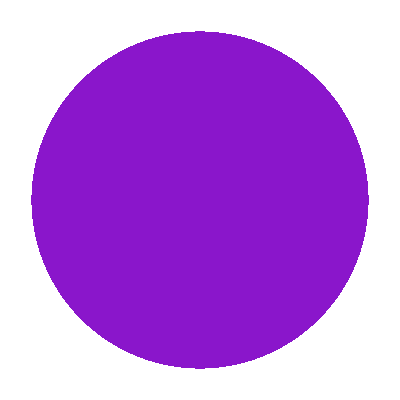

In [13]:
plot1.to_ipython_image()

In [14]:
plot2 = openmc.Plot.from_geometry(geometry)
plot2.width=[300,300]
plot2.color_by = 'material'
plot2.basis='xz'

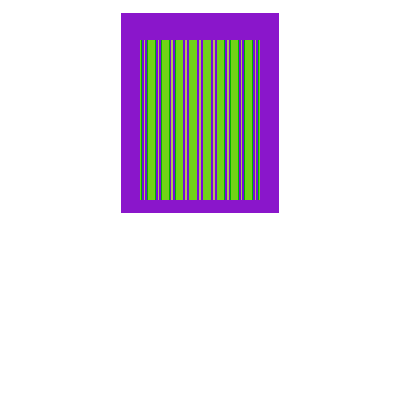

In [15]:
plot2.to_ipython_image()

In [16]:
# OpenMC simulation parameters
batches = 200
inactive = 40
particles = 10000

# Instantiate a Settings object
settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
#settings_file.output = {'tallies': True}

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-0.63, -0.63,-0.63, 0.63, 0.63,0.63]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.Source(space=uniform_dist)

# Export to "settings.xml"
settings_file.export_to_xml()

In [17]:
# Instantiate an empty Tallies object
tallies_file=openmc.Tallies()

In [18]:
#Create mesh which will be used for tally
mesh = openmc.RegularMesh()
mesh.dimension=[1000,1000,1]
mesh.lower_left=[-70,-70,30]
mesh.upper_right=[70,70,31]

#Create mesh filter for tally
mesh_filter=openmc.MeshFilter(mesh)

#Create mesh tally to score flux and fission rate
tally=openmc.Tally(name='flux')
tally.filters=[mesh_filter]
tally.scores=['flux','fission']
tallies_file.append(tally)


In [19]:
#Export to "tallies.xml"
tallies_file.export_to_xml()

In [20]:

openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      139/1    0.97802    0.98639 +/- 0.00136
      140/1    0.96321    0.98616 +/- 0.00137
      141/1    0.99044    0.98620 +/- 0.00136
      142/1    0.99289    0.98627 +/- 0.00135
      143/1    0.97976    0.98621 +/- 0.00133
      144/1    0.97977    0.98614 +/- 0.00132
      145/1    0.96217    0.98591 +/- 0.00133
      146/1    0.99516    0.98600 +/- 0.00132
      147/1    0.98696    0.98601 +/- 0.00131
      148/1    0.99759    0.98612 +/- 0.00130
      149/1    0.99322    0.98618 +/- 0.00129
      150/1    0.99791    0.98629 +/- 0.00128
      151/1    0.97446    0.98618 +/- 0.00128
      152/1    0.98225    0.98615 +/- 0.00126
      153/1    0.97170    0.98602 +/- 0.00126
      154/1    0.99648    0.98611 +/- 0.00125
      155/1    0.99177    0.98616 +/- 0.00124
      156/1    0.98386    0.98614 +/- 0.00123
      157/1    0.99295    0.98620 +/- 0.00122
      158/1    0.98552    0.98619 +/- 0.00121
      159/1    0.96631    0.98603 +/- 0.00121
      160/1    0.97339    0.98592 

In [21]:
# Load the last statepoint file
sp = openmc.StatePoint('statepoint.200.h5')

In [22]:
tally=sp.get_tally(scores=['flux'])
print(tally)

Tally
	ID             =	1
	Name           =	flux
	Filters        =	MeshFilter
	Nuclides       =	total
	Scores         =	['flux', 'fission']
	Estimator      =	tracklength


In [23]:
tally.sum

array([[[0., 0.]],

       [[0., 0.]],

       [[0., 0.]],

       ...,

       [[0., 0.]],

       [[0., 0.]],

       [[0., 0.]]])

In [24]:
print(tally.mean.shape)
(tally.mean,tally.std_dev)

(1000000, 1, 2)


(array([[[0., 0.]],
 
        [[0., 0.]],
 
        [[0., 0.]],
 
        ...,
 
        [[0., 0.]],
 
        [[0., 0.]],
 
        [[0., 0.]]]),
 array([[[0., 0.]],
 
        [[0., 0.]],
 
        [[0., 0.]],
 
        ...,
 
        [[0., 0.]],
 
        [[0., 0.]],
 
        [[0., 0.]]]))

In [25]:
flux=tally.get_slice(scores=['flux'])
fission=tally.get_slice(scores=['fission'])
print(flux)


Tally
	ID             =	2
	Name           =	flux
	Filters        =	MeshFilter
	Nuclides       =	total
	Scores         =	['flux']
	Estimator      =	tracklength


In [26]:
flux.std_dev.shape=(1000,1000)
flux.mean.shape=(1000,1000)
fission.std_dev.shape=(1000,1000)
fission.mean.shape=(1000,1000)

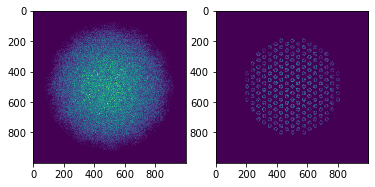

In [27]:
fig=plt.subplot(121)
fig.imshow(flux.mean)
fig2=plt.subplot(122)
fig2.imshow(fission.mean)